In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.dynamics import msd_from_gsd
import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import os

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
project = signac.get_project("../validation/")
job_filter = {"remove_hydrogens": True, "remove_charges": False, "pressure": 0.0013933}

def kT_to_T(kT, epsilon):
    return ((kT*epsilon)/8.31446262) - 273.15

In [3]:
for job in project.find_jobs({"doc.npt_equilibrated": False, "sigma_scale": 0.955}):
    print(job.sp.kT, job.sp.sigma_scale, job.path)
    #job.doc.avg_density = den_dict[job.sp.kT]
    #job.doc.skip_npt_equil = True
    

3.0 0.955 /home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/73e2a18dd6e440ba0066c934fcb829e0
2.8 0.955 /home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/51e475756aeadda668351a024760dcda
3.1 0.955 /home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/100888a4bbe8114d13b7c682ba77a678
2.9 0.955 /home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/9a2350bfd349debae443b6dd5f1beb2f
2.7 0.955 /home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/393a1cc581d5324e470714d7c681dcac


In [4]:
print(len([j for j in project if j.doc.npt_equilibrated]))
print(len([j for j in project if not j.doc.npt_equilibrated]))

34
8


In [5]:
def combine_log_files(job, ensemble="npt", value="mdcomputeThermodynamicQuantitiesvolume"):
    arrays = []
    if ensemble == "npt":
        n_runs = job.doc.npt_runs
    elif ensemble == "nvt":
        n_runs = job.doc.nvt_runs

    for i in range(n_runs):
        fpath = job.fn(f"log-{ensemble}{i}.txt")
        data = np.genfromtxt(fpath, names=True)
        data_array = data[value]
        arrays.append(data_array)
    return np.concatenate(arrays)

/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation/workspace/100888a4bbe8114d13b7c682ba77a678 3.1


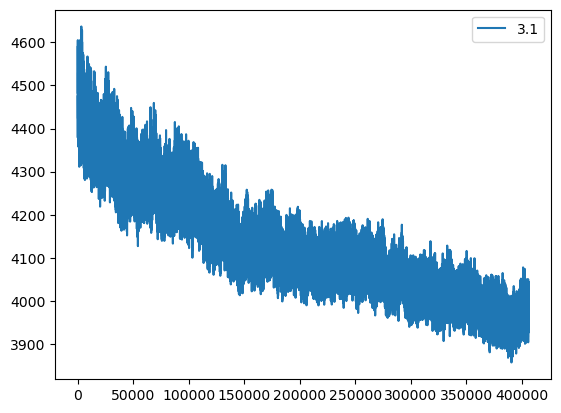

In [8]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "kT": 3.1,
    "doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}

for job in project.find_jobs(filter=job_filter):
    if job.doc.npt_runs == 0:
        print(job.id)
        continue
    fpath = job.fn(f"log-npt{job.doc.npt_runs-1}.txt")
    data = np.genfromtxt(fpath, names=True)
    vol = combine_log_files(job)
    pe = combine_log_files(job=job, value="mdcomputeThermodynamicQuantitiespotential_energy")
    temp = combine_log_files(job=job, value="mdcomputeThermodynamicQuantitieskinetic_temperature")
    plt.plot(vol[8000:], label=job.sp.kT)
    print(job.path, job.sp.kT)

plt.legend()

# Check for NPT Equilibration:

In [26]:
for job in project.find_jobs(filter={"doc.npt_equilibrated": False,"kT": 3.0}):
    #if job.doc.npt_runs == 0:
    #    continue
    fpath = job.fn(f"log-npt{job.doc.npt_runs-1}.txt")
    data = np.genfromtxt(fpath, names=True)
    #vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    #pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    vol = combine_log_files(job=job)
    pe = combine_log_files(job=job, value="mdcomputeThermodynamicQuantitiespotential_energy")
    if job.doc.npt_runs == 1:
        sample_idx = len(vol)//2
    else:
        sample_idx = -30000
    vol_eq = is_equilibrated(vol[sample_idx:], threshold_fraction=0.15, threshold_neff=200)[0]
    pe_eq = is_equilibrated(pe[sample_idx:], threshold_fraction=0.15, threshold_neff=200)[0]
    print(job.sp.kT, vol_eq, pe_eq)
    if all([vol_eq, pe_eq]):
        print("equilibrated")
        job.doc.npt_equilibrated = True
    print()

3.0 False False

3.0 False False



# Sample Volume:

In [23]:
for job in project.find_jobs(filter={"doc.npt_equilibrated": True, "doc.volume_sampled": False}):
    print(job.id, job.sp.kT)
    fpath = job.fn(f"log-npt{job.doc.npt_runs-1}.txt")
    data = np.genfromtxt(fpath, names=True)
    #vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    #pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
    vol = combine_log_files(job=job)
    #pe = combine_log_files(job=job, value="mdcomputeThermodynamicQuantitiespotential_energy")
    if job.doc.npt_runs == 1:
        sample_idx = len(vol)//2
    else:
        sample_idx = 3050
    try:
        uncorr_sample, uncorr_indices, prod_start, Neff = equil_sample(
                vol[sample_idx:], threshold_fraction=0.15, threshold_neff=200
            )
    except ValueError:
        #job.doc.npt_equilibrated = False
        print("error")
        continue
    vol_nm = uncorr_sample * (job.doc.ref_length**3) * Unit(f"{job.doc.ref_length_units}**3")
    vol_cm = vol_nm.to("cm**3")
    job.doc.avg_vol = np.mean(vol_cm.value)
    job.doc.vol_std = np.std(vol_cm.value)
    np.savetxt(job.fn("vol_cc.txt"), vol_cm.value)
    with gsd.hoomd.open(job.fn("restart.gsd")) as traj:
        snap = traj[0]
        reduced_mass = sum(snap.particles.mass)
        mass_amu = reduced_mass * job.doc.ref_mass * Unit(job.doc.ref_mass_units)
        mass_g = mass_amu.to("g")
        job.doc.mass_g = mass_g.value
    job.doc.avg_density = job.doc.mass_g / job.doc.avg_vol
    job.doc.density_std = job.doc.mass_g / job.doc.vol_std
    job.doc.volume_sampled = True

28aa0133175e9cf18fd68e541cb012ee 4.4


/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)
/home/chrisjones4/miniconda3/envs/jankflow/lib/python3.9/site-packages/synced_collections/numpy_utils.py:43: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


212e36add95bb5744b05aa8ce8d29449 4.6
96282e58fc96112640e1330198828903 4.0
24e102558a3471c0accad805e64ff332 4.2


# Analysis: Plot Density vs Temperature

2.0 1.3686785297722928
2.2 1.3557969861989738
2.4 1.3392703348028023
2.5 1.3231743070374549
2.6 1.3158424105494935
3.2 1.2425106980982334
3.4 1.1712495596403212
3.6 1.1021776913184336
3.8 1.040777507712581
4.0 0.9754124522622935
4.2 0.9035164883121194
4.4 0.8283214502831906
4.6 0.7411607091637776


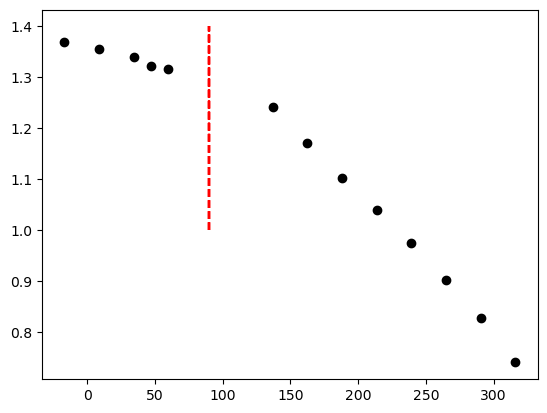

In [4]:
job_filter = {"remove_hydrogens": True, "remove_charges": False, "doc.volume_sampled": True, "sigma_scale": 0.955}
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    if kT < 2.0: continue
    job = list(job)[0]
    print(kT, job.doc.avg_density)
    #print(kT, job.path)
    T = kT_to_T(job.sp.kT, epsilon=1065)
    plt.plot(T, job.doc.avg_density, "ko")
    #plt.errorbar(x=kT, y=job.doc.avg_vol, yerr=job.doc.vol_std, marker="o", c="k")
    plt.vlines(x=90, ymin=1.0, ymax=1.4, ls="--", color="red")

In [ ]:
for job in project.find_jobs({"doc.volume_sampled": True}):
    if not job.isfile("trajectory-nvt0.gsd"):
        print(job.sp.kT)

In [15]:
job.project.path

'/home/erjank_project/chrisjones/1-PPS-MSIBI/PPS-MSIBI/pps-msibi/validation'